# Load S&P 500 Daily Bar Data

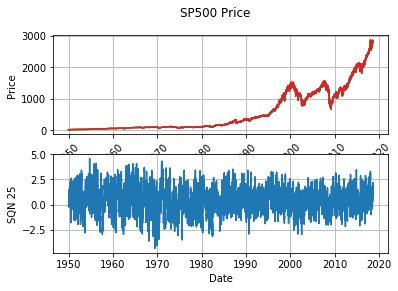

In [ ]:
import pandas as pd
import os
import math
import matplotlib.pyplot as plt


SP500_BASE_DIRECTORY = "D:\\Users\\Shane\\\Dropbox\\PyCharm Projects\\Market_Analysis\\"
#SP500_BASE_DIRECTORY = os.getcwd()
SP500_DATA_DIRECTORY = SP500_BASE_DIRECTORY + "\\data\\"
SP500_DATA_FILENAME = "SP500.csv"
OUTPUT_DIRECTORY = SP500_BASE_DIRECTORY + "\\output\\"
OUTPUT_EXCEL_FILENAME = "Bear Market Analysis.xlsx"

sp500_df = pd.read_csv(SP500_DATA_DIRECTORY + SP500_DATA_FILENAME)
sp500_df['Date'] = pd.to_datetime(sp500_df.Date)
#sp500_df = sp500_df.sort_values(by=['Date'], ascending=False)

fig = plt.figure()
ax1 = plt.subplot(2, 1, 1)
ax1.plot(sp500_df['Date'], sp500_df['SP500_Open'])
ax1.plot(sp500_df['Date'], sp500_df['SP500_High'])
ax1.plot(sp500_df['Date'], sp500_df['SP500_Low'])
ax1.plot(sp500_df['Date'], sp500_df['SP500_Close'])
plt.ylabel('Price')
ax1.grid(True)

ax2 = plt.subplot(2, 1, 2)
ax2.plot(sp500_df['Date'], sp500_df['SP500_SQN25'])
plt.ylabel('SQN 25')
ax2.grid(True)

for label in ax1.xaxis.get_ticklabels():
    label.set_rotation(45)

plt.xlabel('Date')
plt.suptitle('SP500 Price')
plt.show()

In [3]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.graph_objs import *

plotly.tools.set_credentials_file(username='shane.brewer', api_key='Utd2w2H5xUb4MfnMmlNZ')
plotly.tools.set_config_file(world_readable=True, sharing='public')

sp500_price_trace = go.Candlestick(
    x=sp500_df['Date'],
    close=sp500_df['SP500_Close'],
    high=sp500_df['SP500_High'],
    low=sp500_df['SP500_Low'],
    open=sp500_df['SP500_Open'],
    xaxis="x",
    yaxis="y"
)

sqn25_trace = go.Scatter(
    x=sp500_df['Date'],
    y=sp500_df['SP500_SQN25'],
    xaxis="x",
    yaxis="y2"
)

data = [sp500_price_trace, sqn25_trace]

layout = {
    "hovermode": "closest", 
    "showlegend": False, 
    "title": "S&P500 Price Chart", 
    "xaxis": {
        "anchor": "y2",
        "domain": [0, 1],
        "title": "Date",
        "autorange": True,
        "rangeselector": {
            "x": 0.5, 
            "y": -0.055, 
            "buttons": [
            {
                "count": 1, 
                "label": "RESET", 
                "step": "all"
            }, 
            {
                "count": 1, 
                "label": "1 YR", 
                "step": "year", 
                "stepmode": "backward"
            }, 
            {
                "count": 3, 
                "label": "3 MO", 
                "step": "month", 
                "stepmode": "backward"
            }, 
            {
                "count": 1, 
                "label": "1 MO", 
                "step": "month", 
                "stepmode": "backward"
            }
            ], 
            "font": {"size": 9}, 
            "visible": True, 
            "xanchor": "center"
        }, 
    }, 
    "yaxis": {
        "anchor": "x",
        "domain": [0.27, 0.95],
        "title": "Price",
        "autorange": True
    },
    "yaxis2": {
        "anchor": "x",
        "domain": [0.05, 0.23],
        "title": "SQN25",
        "autorange": True
    }
}

fig = Figure(data=data, layout=layout)
py.iplot(fig, filename='SP500_Price_Chart') 

OSError: [Errno 22] Invalid argument

In [4]:
sqn25_trace = go.Scatter(
    x=sp500_df['Date'],
    y=sp500_df['SP500_SQN25']
)
data = [sp500_price_trace, sqn25_trace]
layout = {
    "hovermode": "closest", 
    "showlegend": False, 
    "title": "S&P500 Price Chart", 
    "xaxis": {
        "domain": [0, 1], 
        "title": "Date"
    }, 
    "yaxis": {
        "domain": [0, 1],
        "title": "Price"
    }
}

fig = Figure(data=data, layout=layout)
py.iplot(fig, filename='SP500_Price_Chart')

In [5]:
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows

sp500_drawdown_df = sp500_df[['Date', 'SP500_Close']]
sp500_drawdown_df = sp500_drawdown_df.assign(Close_Price_Diff=sp500_drawdown_df['SP500_Close'] -
                                                              sp500_drawdown_df['SP500_Close'].shift(1))
sp500_drawdown_df = sp500_drawdown_df.assign(Close_Price_Diff_Percentage=sp500_drawdown_df['SP500_Close'].pct_change() * 100)

sp500_drawdown_df = sp500_drawdown_df.assign(Cumulative_Price_Diff=sp500_drawdown_df['Close_Price_Diff'].cumsum())

sp500_drawdown_df = sp500_drawdown_df.assign(Max_Gain=sp500_drawdown_df['Cumulative_Price_Diff'].expanding(2).max())

sp500_drawdown_df = sp500_drawdown_df.assign(Peak_To_Trough=sp500_drawdown_df['Cumulative_Price_Diff'] -
                                                      sp500_drawdown_df['Max_Gain'])
sp500_drawdown_df = sp500_drawdown_df.assign(Peak_To_Trough_Percentage=sp500_drawdown_df['Peak_To_Trough'] /
                                                                 (sp500_drawdown_df['SP500_Close'] -
                                                                 sp500_drawdown_df['Peak_To_Trough']) * 100)
wb = Workbook()
ws = wb.create_sheet("Drawdowns")
ws.title = "Drawdowns"
for row in dataframe_to_rows(sp500_drawdown_df, index=True, header=True):
    ws.append(row)
wb.save(OUTPUT_DIRECTORY + OUTPUT_EXCEL_FILENAME)

drawdown_percentage_threshold = 20
max_drawdown_percentage = 0
drawdown_df = pd.DataFrame()

for row in sp500_drawdown_df.itertuples():
    if math.isnan(getattr(row, 'Peak_To_Trough')):
        continue
    if math.isclose(getattr(row, 'Peak_To_Trough'), 0, rel_tol=1e-5) and max_drawdown_percentage < \
            (drawdown_percentage_threshold * -1):
        # Now making new highs, and the last drawdown reached the minimum threshold
        start_date = sp500_drawdown_df.at[last_peak_index, 'Date']
        end_date = sp500_drawdown_df.at[max_drawdown_index, 'Date']
        num_days = (sp500_drawdown_df.at[max_drawdown_index, 'Date'] -
                    sp500_drawdown_df.at[last_peak_index, 'Date']).days

        df = pd.DataFrame({'Start_Date': start_date,
                           'Start_Date_Index': last_peak_index,
                           'End_Date': end_date,
                           'End_Date_Index': max_drawdown_index,
                           'Total_Drawdown_Percentage': max_drawdown_percentage,
                           'Num_Days': num_days}, index=[0])
        
        drawdown_df = drawdown_df.append(df, ignore_index=True)
        last_peak_index = row.Index
        max_drawdown_percentage = 0
        max_drawdown_index = 0
    elif math.isclose(getattr(row, 'Peak_To_Trough'), 0, rel_tol=1e-5):
        # Now making new highs but didn't reach minimum drawdown percentage threshold. Reset variables.
        last_peak_index = row.Index
        max_drawdown_percentage = 0
        max_drawdown_index = 0
    elif max_drawdown_percentage > getattr(row, 'Peak_To_Trough_Percentage'):
        max_drawdown_percentage = getattr(row, 'Peak_To_Trough_Percentage')
        max_drawdown_index = row.Index
pd.DataFrame(drawdown_df)

,End_Date,End_Date_Index,Num_Days,Start_Date,Start_Date_Index,Total_Drawdown_Percentage
0,1957-10-22,1958,445,1956-08-03,1652,-21.474617
1,1962-06-26,3135,196,1961-12-12,3000,-27.973568
2,1966-10-07,4215,240,1966-02-09,4048,-22.177334
3,1970-05-26,5100,543,1968-11-29,4731,-36.061641
4,1974-10-03,6201,630,1973-01-11,5765,-48.203593
5,1982-08-12,8186,622,1980-11-28,7756,-27.113578
6,1987-12-04,9530,101,1987-08-25,9459,-33.509517
7,2002-10-09,13273,929,2000-03-24,12640,-49.146950
8,2009-03-09,14886,517,2007-10-09,14531,-56.775389


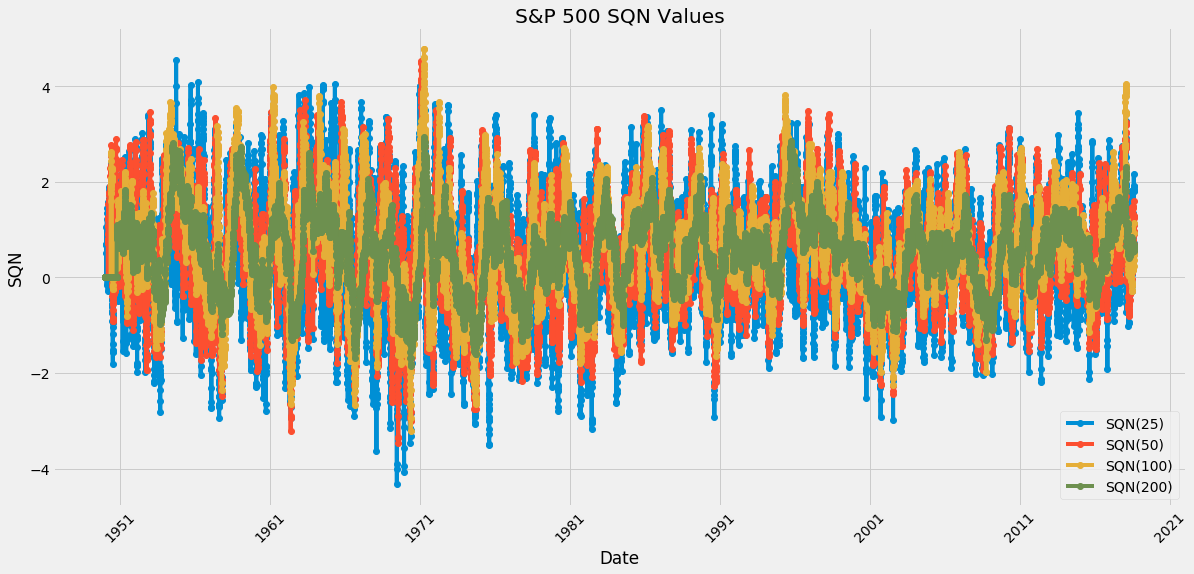

In [6]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style

style.use('fivethirtyeight')
fig = plt.figure()
fig.set_size_inches(18.5, 9.5)
ax1 = plt.subplot2grid((1, 1), (0, 0))
ax1.plot_date(sp500_df['Date'], sp500_df['SP500_SQN25'], linestyle='-', label='SQN(25)')
ax1.plot_date(sp500_df['Date'], sp500_df['SP500_SQN50'], linestyle='-', label='SQN(50)')
ax1.plot_date(sp500_df['Date'], sp500_df['SP500_SQN100'], linestyle='-', label='SQN(100)')
ax1.plot_date(sp500_df['Date'], sp500_df['SP500_SQN200'], linestyle='-', label='SQN(200)')
for label in ax1.xaxis.get_ticklabels():
    label.set_rotation(45)
ax1.grid(True)

plt.title('S&P 500 SQN Values')
plt.xlabel('Date')
plt.ylabel('SQN')
plt.legend()
plt.subplots_adjust(left=0.09, bottom=0.20, right=0.94, top=0.90, wspace=0.2, hspace=0)
plt.savefig(OUTPUT_DIRECTORY + 'SP500_SQN.png', dpi=100)
plt.show()

In [7]:
import statistics

sqn_df = pd.DataFrame()

sqn25_avg = statistics.mean(sp500_df['SP500_SQN25'])
sqn25_stdev = statistics.stdev(sp500_df['SP500_SQN25'])
sqn25_min = min(sp500_df['SP500_SQN25'])
sqn25_max = max(sp500_df['SP500_SQN25'])

sqn50_avg = statistics.mean(sp500_df['SP500_SQN50'])
sqn50_stdev = statistics.stdev(sp500_df['SP500_SQN50'])
sqn50_min = min(sp500_df['SP500_SQN50'])
sqn50_max = max(sp500_df['SP500_SQN50'])

sqn100_avg = statistics.mean(sp500_df['SP500_SQN100'])
sqn100_stdev = statistics.stdev(sp500_df['SP500_SQN100'])
sqn100_min = min(sp500_df['SP500_SQN100'])
sqn100_max = max(sp500_df['SP500_SQN100'])
    
sqn200_avg = statistics.mean(sp500_df['SP500_SQN200'])
sqn200_stdev = statistics.stdev(sp500_df['SP500_SQN200'])
sqn200_min = min(sp500_df['SP500_SQN200'])
sqn200_max = max(sp500_df['SP500_SQN200'])

sqn_df = pd.DataFrame({
    'START_DATE': sp500_df.loc[0, 'Date'],
    'END_DATE': sp500_df.loc[len(sp500_df)-1, 'Date'],
    'SQN25_AVG': sqn25_avg, 
    'SQN25_STDEV': sqn25_stdev,
    'SQN25_MIN': sqn25_min,
    'SQN25_MAX': sqn25_max,
    'SQN50_AVG': sqn50_avg,
    'SQN50_STDEV': sqn50_stdev,
    'SQN50_MIN': sqn50_min,
    'SQN50_MAX': sqn50_max,
    'SQN100_AVG': sqn100_avg,
    'SQN100_STDEV': sqn100_stdev,
    'SQN100_MIN': sqn100_min,
    'SQN100_MAX': sqn100_max,
    'SQN200_AVG': sqn200_avg,
    'SQN200_STDEV': sqn200_stdev,
    'SQN200_MIN': sqn200_min,
    'SQN200_MAX': sqn200_max}, index=[0])


for row in drawdown_df.itertuples():
    # Slice the SP500 df based on start and end dates of the drawdown
    start_index = getattr(row, 'Start_Date_Index')
    end_index = getattr(row, 'End_Date_Index')
    drawdown_slice_df = sp500_df[start_index:end_index + 1]
    
    sqn25_avg = statistics.mean(drawdown_slice_df['SP500_SQN25'])
    sqn25_stdev = statistics.stdev(drawdown_slice_df['SP500_SQN25'])
    sqn25_min = min(drawdown_slice_df['SP500_SQN25'])
    sqn25_max = max(drawdown_slice_df['SP500_SQN25'])
    
    sqn50_avg = statistics.mean(drawdown_slice_df['SP500_SQN50'])
    sqn50_stdev = statistics.stdev(drawdown_slice_df['SP500_SQN50'])
    sqn50_min = min(drawdown_slice_df['SP500_SQN50'])
    sqn50_max = max(drawdown_slice_df['SP500_SQN50'])
    
    sqn100_avg = statistics.mean(drawdown_slice_df['SP500_SQN100'])
    sqn100_stdev = statistics.stdev(drawdown_slice_df['SP500_SQN100'])
    sqn100_min = min(drawdown_slice_df['SP500_SQN100'])
    sqn100_max = max(drawdown_slice_df['SP500_SQN100'])
        
    sqn200_avg = statistics.mean(drawdown_slice_df['SP500_SQN200'])
    sqn200_stdev = statistics.stdev(drawdown_slice_df['SP500_SQN200'])
    sqn200_min = min(drawdown_slice_df['SP500_SQN200'])
    sqn200_max = max(drawdown_slice_df['SP500_SQN200'])
    
    df = pd.DataFrame({
        'START_DATE': getattr(row, 'Start_Date'),
        'END_DATE': getattr(row, 'End_Date'),
        'SQN25_AVG': sqn25_avg, 
        'SQN25_STDEV': sqn25_stdev,
        'SQN25_MIN': sqn25_min,
        'SQN25_MAX': sqn25_max,
        'SQN50_AVG': sqn50_avg,
        'SQN50_STDEV': sqn50_stdev,
        'SQN50_MIN': sqn50_min,
        'SQN50_MAX': sqn50_max,
        'SQN100_AVG': sqn100_avg,
        'SQN100_STDEV': sqn100_stdev,
        'SQN100_MIN': sqn100_min,
        'SQN100_MAX': sqn100_max,
        'SQN200_AVG': sqn200_avg,
        'SQN200_STDEV': sqn200_stdev,
        'SQN200_MIN': sqn200_min,
        'SQN200_MAX': sqn200_max}, index=[0])

    sqn_df = sqn_df.append(df, ignore_index=True)

# Create a table of background colors based on the SQN values


price_table = go.Table(
    header=dict(values=list(sqn_df.columns),
                fill=dict(color='#C2D4FF'),
                align=['left'] * 5,
                font=dict(color='black', size=12)),
    cells=dict(values=[sqn_df.START_DATE,
                       sqn_df.END_DATE,
                       sqn_df.SQN25_AVG,
                       sqn_df.SQN25_STDEV,
                       sqn_df.SQN25_MIN,
                       sqn_df.SQN25_MAX,
                       sqn_df.SQN50_AVG,
                       sqn_df.SQN50_STDEV,
                       sqn_df.SQN50_MIN,
                       sqn_df.SQN50_MAX,
                       sqn_df.SQN100_AVG,
                       sqn_df.SQN100_STDEV,
                       sqn_df.SQN100_MIN,
                       sqn_df.SQN100_MAX,
                       sqn_df.SQN200_AVG,
                       sqn_df.SQN200_STDEV,
                       sqn_df.SQN200_MIN,
                       sqn_df.SQN200_MAX],
               fill=dict(color='#F5F8FF'),
               align=['left'] * 5))

table_data = [price_table]
py.iplot(table_data, filename='Bear_Market_Research_Table')

In [8]:
BEAR_MARKET_SQN_VALUE = 0
sqn100_df = sp500_df[['Date', 'SP500_SQN100']]
sqn100_df = sqn100_df.assign(SQN100_SHIFT=sqn100_df['SP500_SQN100'].shift(-1))
sqn100_df = sqn100_df.assign(BEAR_TRIGGER=(sqn100_df['SP500_SQN100'] < BEAR_MARKET_SQN_VALUE) & 
                             (sqn100_df['SQN100_SHIFT'] > BEAR_MARKET_SQN_VALUE))
sqn_bearish_crossover_dates = sqn100_df[(sqn100_df.BEAR_TRIGGER == True)]
sqn_bearish_crossover_dates = sqn_bearish_crossover_dates.assign(Num_Days_Between_Signals=((sqn_bearish_crossover_dates['Date'] -
                                                                                            sqn_bearish_crossover_dates['Date'].shift(-1)) * -1))
sqn100_drawdown_df = sp500_drawdown_df[sp500_drawdown_df.index.isin(sqn_bearish_crossover_dates.index)]
sqn_bearish_crossover_dates['To_Date_Drawdown'] = sqn100_drawdown_df['Peak_To_Trough_Percentage']

# Get the maximum drawdown experienced after this signal
for row in sqn_bearish_crossover_dates.itertuples():
    i = row.Index
    while(sp500_drawdown_df[['Peak_To_Trough'][i]] > 0):
        i += 1

print(sqn_bearish_crossover_dates)

SyntaxError: invalid syntax (<ipython-input-8-bee3a836d218>, line 15)

In [9]:
import datetime

sqn_filtered_bearish_crossover_dates = sqn_bearish_crossover_dates[(sqn_bearish_crossover_dates.Num_Days_Between_Signals >= 
                                                                    datetime.timedelta(days=30))]
print(sqn_filtered_bearish_crossover_dates)

NameError: name 'sqn_bearish_crossover_dates' is not defined

In [10]:
STRONG_BEAR_MARKET_SQN_VALUE = -0.7
strong_bear_sqn100_df = sp500_df[['Date', 'SP500_SQN100']]
strong_bear_sqn100_df = strong_bear_sqn100_df.assign(SQN100_SHIFT=strong_bear_sqn100_df['SP500_SQN100'].shift(-1))
strong_bear_sqn100_df = strong_bear_sqn100_df.assign(BEAR_TRIGGER=(strong_bear_sqn100_df['SP500_SQN100'] < 
                                                                   STRONG_BEAR_MARKET_SQN_VALUE) & 
                                                     (strong_bear_sqn100_df['SQN100_SHIFT'] > STRONG_BEAR_MARKET_SQN_VALUE))
sqn_strong_bearish_crossover_dates = strong_bear_sqn100_df[(strong_bear_sqn100_df.BEAR_TRIGGER == True)]
sqn_strong_bearish_crossover_dates = sqn_strong_bearish_crossover_dates.assign(Num_Days_Between_Signals=((sqn_strong_bearish_crossover_dates['Date'] -
                                                                                            sqn_strong_bearish_crossover_dates['Date'].shift(-1)) * -1))
print(sqn_strong_bearish_crossover_dates)

            Date  SP500_SQN100  SQN100_SHIFT  BEAR_TRIGGER  \
373   1951-06-29     -0.803658     -0.650798          True   
827   1953-04-28     -0.736992     -0.611538          True   
838   1953-05-13     -0.783024     -0.685784          True   
843   1953-05-20     -0.739967     -0.680749          True   
878   1953-07-08     -0.726139     -0.678971          True   
907   1953-08-18     -0.729969     -0.634582          True   
946   1953-10-14     -0.857185     -0.580518          True   
1692  1956-10-01     -0.799643     -0.380497          True   
1734  1956-11-30     -0.846842     -0.625802          True   
1742  1956-12-12     -0.729666     -0.630021          True   
1751  1956-12-27     -0.741537     -0.688470          True   
1763  1957-01-15     -0.738439     -0.638704          True   
1768  1957-01-22     -0.772822     -0.655496          True   
1779  1957-02-06     -0.812764     -0.640079          True   
1787  1957-02-18     -0.776059     -0.601205          True   
1795  19

In [11]:
import datetime

sqn_filtered_strong_bearish_crossover_dates = sqn_strong_bearish_crossover_dates[(sqn_strong_bearish_crossover_dates.Num_Days_Between_Signals >= 
                                                                    datetime.timedelta(days=30))]
print(sqn_filtered_strong_bearish_crossover_dates)

            Date  SP500_SQN100  SQN100_SHIFT  BEAR_TRIGGER  \
373   1951-06-29     -0.803658     -0.650798          True   
843   1953-05-20     -0.739967     -0.680749          True   
878   1953-07-08     -0.726139     -0.678971          True   
907   1953-08-18     -0.729969     -0.634582          True   
946   1953-10-14     -0.857185     -0.580518          True   
1692  1956-10-01     -0.799643     -0.380497          True   
1819  1957-04-04     -0.741158     -0.599600          True   
2035  1958-02-12     -0.715355     -0.567988          True   
2530  1960-01-29     -0.811910     -0.483020          True   
2560  1960-03-14     -0.742279     -0.518048          True   
2615  1960-06-01     -0.940238     -0.692506          True   
2724  1960-11-03     -0.852624     -0.641185          True   
3078  1962-04-04     -0.733380     -0.685936          True   
3218  1962-10-23     -0.927305     -0.293349          True   
3892  1965-06-29     -1.157849     -0.639269          True   
4083  19